In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import sys
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plt
import tqdm
from sklearn import metrics

In [3]:
try:
    from urllib import urlretrieve
except ImportError:
    from urllib.request import urlretrieve
def download_url(url, model_dir='~/.torch/', overwrite=False):
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

In [4]:
imagenet_data_path='imagenet_1k'
if not os.path.isdir(imagenet_data_path):
    os.makedirs(imagenet_data_path, exist_ok=True)
    download_url('https://hanlab.mit.edu/files/OnceForAll/ofa_cvpr_tutorial/imagenet_1k.zip', model_dir='data')
    #! cd data && unzip imagenet_1k 1>/dev/null && cd ..
    #! mv data/imagenet_1k imagenet_1k
    #! rm -rf data

In [5]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.applications import mobilenet,mobilenet_v2,inception_v3,efficientnet
from tensorflow.compat.v1.keras.backend import set_session 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
set_session(sess)

2.4.1


In [12]:
if False:
    net_model=efficientnet
    model=net_model.EfficientNetB0(include_top=True, weights='imagenet', input_shape=(224,224,3))
elif False:
    net_model=mobilenet_v2
    model=net_model.MobileNetV2(include_top=True, weights='imagenet', input_shape=(224,224,3))
else:
    import efficientnet.tfkeras as enet
    net_model=enet
    model=enet.EfficientNetB0(include_top=True, weights='imagenet', input_shape=(224,224,3))

In [7]:
import math
from torchvision import datasets, transforms
def torch_transforms_imagenet_eval(
        img_size=224,
        crop_pct=0.875):
    if isinstance(img_size, (tuple, list)):
        assert len(img_size) == 2
        if img_size[-1] == img_size[-2]:
            # fall-back to older behaviour so Resize scales to shortest edge if target is square
            scale_size = int(math.floor(img_size[0] / crop_pct))
        else:
            scale_size = tuple([int(x / crop_pct) for x in img_size])
    else:
        #print(img_size)
        scale_size = int(math.floor(img_size / crop_pct))

    tfl = [
        transforms.Resize(scale_size, Image.BILINEAR),
        transforms.CenterCrop(img_size),
    ]

    return transforms.Compose(tfl)

torch_preprocess=torch_transforms_imagenet_eval()
def get_img(img_path):
    if False:
        img = image.load_img(img_path, target_size=(224,224))
    else:
        img = Image.open(img_path)
        img=img.convert('RGB')
        img = torch_preprocess(img)
    return img

In [27]:
IMAGENET_VAL=os.path.join(imagenet_data_path,'val')

ILSVRC2012_val_00000293.JPEG [394   0  48 395 389] [('n02640242', 'sturgeon', 0.35224062), ('n01440764', 'tench', 0.26742876), ('n01695060', 'Komodo_dragon', 0.050613586), ('n02641379', 'gar', 0.044479977), ('n02514041', 'barracouta', 0.042948104)]
ILSVRC2012_val_00048840.JPEG [  1 392 393 397  29] [('n01443537', 'goldfish', 0.8734817), ('n02606052', 'rock_beauty', 0.0042485325), ('n02607072', 'anemone_fish', 0.0017786213), ('n02655020', 'puffer', 0.0017220274), ('n01632777', 'axolotl', 0.0013513835)]


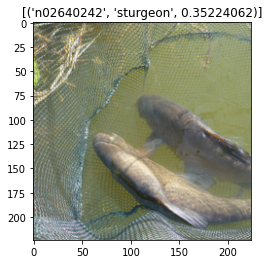

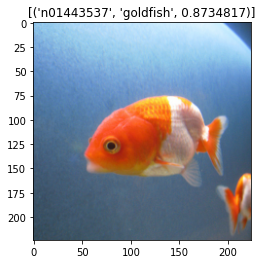

In [70]:
for i,img_dir in enumerate(sorted(os.listdir(IMAGENET_VAL))[:2]):
    img_path=sorted(os.listdir(os.path.join(IMAGENET_VAL,img_dir)))[0]
    img = get_img(os.path.join(IMAGENET_VAL,img_dir,img_path)) #image.load_img(os.path.join('val',img_path), target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = net_model.preprocess_input(x)
    preds = model.predict(x)  
    top_indices = preds[0].argsort()[-5:][::-1]
    print(img_path, top_indices,tf.keras.applications.imagenet_utils.decode_predictions(preds, top=5)[0])
    plt.figure(i)
    plt.grid(False)
    plt.title(tf.keras.applications.imagenet_utils.decode_predictions(preds, top=1)[0])
    imgplot = plt.imshow(img)
plt.show()

In [42]:
print()
import json
synset_indices=[]
synset2modelIndex={}
with open(os.path.join(os.path.expanduser("~"),'.keras/models/imagenet_class_index.json')) as json_file:
    data = json.load(json_file)
    #print(data["999"])
    for class_id in range(1000):
        synset=data[str(class_id)][0]
        synset_indices.append(synset)
        synset2modelIndex[synset]=class_id
print(synset_indices[:5])


['n01440764', 'n01443537', 'n01484850', 'n01491361', 'n01494475']


In [52]:
gt_val=[]
for img_dir in sorted(os.listdir(IMAGENET_VAL)):
    for img_path in sorted(os.listdir(os.path.join(IMAGENET_VAL,img_dir))):
        gt_val.append(synset2modelIndex[img_dir])
gt_val=np.array(gt_val)
print(gt_val.shape)

(1000,)


In [107]:
imgs=[]
top_indices_tf=None
for img_dir in tqdm.tqdm(sorted(os.listdir(IMAGENET_VAL))):
    for img_path in sorted(os.listdir(os.path.join(IMAGENET_VAL,img_dir))):
        img = get_img(os.path.join(IMAGENET_VAL,img_dir,img_path)) #image.load_img(os.path.join('val',img_path), target_size=(224,224))
        x = image.img_to_array(img)
        #print(x.shape)
        imgs.append(x)
        if len(imgs)>=128:
            x = net_model.preprocess_input(np.array(imgs))
            preds = model.predict(x)  
            #print(preds.shape)
            top_inds = preds.argsort()[:,-5:][:,::-1]
            #print(top_inds.shape,top_inds)
            if top_indices_tf is None:
                top_indices_tf=top_inds
            else:
                top_indices_tf=np.concatenate((top_indices_tf,top_inds),axis=0)
            imgs=[]

if len(imgs)>0:
    x = net_model.preprocess_input(np.array(imgs))
    preds = model.predict(x)  
    top_inds = preds.argsort()[:,-5:][:,::-1]
    #print(top_inds.shape,top_inds)
    if top_indices_tf is None:
        top_indices_tf=top_inds
    else:
        top_indices_tf=np.concatenate((top_indices_tf,top_inds),axis=0)
    imgs=[]
print(top_indices_tf.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.19it/s]


(1000, 5)


In [108]:
print('top-1 accuracy:',np.mean(top_indices_tf[:,0]==gt_val))
k=5
print('top-5 accuracy:',np.mean(np.sum(top_indices_tf[:,:k]==np.repeat(np.reshape(gt_val,(-1,1)),k,axis=1),axis=1)))

top-1 accuracy: 0.713
top-5 accuracy: 0.916


mobilenet v2:
top-1 accuracy: 0.713
top-5 accuracy: 0.916

efficientnet:
top-1 accuracy: 0.735
top-5 accuracy: 0.913

## TfLite 

In [13]:
import random
def representative_dataset():
    base_dir='imagenet_1k/train'
    train_synsets=os.listdir(base_dir)
    for _ in range(100):
        synset_path=os.path.join(base_dir,random.choice(train_synsets))
        test_image = get_img(os.path.join(synset_path,random.choice(os.listdir(synset_path))))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        test_image = net_model.preprocess_input(test_image)
        yield [test_image]

In [14]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
if False:
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8
#converter.target_spec.supported_types = [tf.float16]
converter.representative_dataset = representative_dataset

In [15]:
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\AVSAVC~1\AppData\Local\Temp\tmp1cf8m5_0\assets


INFO:tensorflow:Assets written to: C:\Users\AVSAVC~1\AppData\Local\Temp\tmp1cf8m5_0\assets


In [16]:
if True:
    open("mymodel.tflite", "wb").write(tflite_quant_model)

In [111]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model, num_threads=8)
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
print('input: ', input_details)
print('output: ', output_details)
interpreter.allocate_tensors()

input:  {'name': 'input_6', 'index': 178, 'shape': array([  1, 224, 224,   3]), 'shape_signature': array([ -1, 224, 224,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
output:  {'name': 'Identity', 'index': 179, 'shape': array([   1, 1000]), 'shape_signature': array([  -1, 1000]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [112]:
top_indices_tflite=[]
for img_dir in tqdm.tqdm(sorted(os.listdir(IMAGENET_VAL))[:1000]):
    for img_path in sorted(os.listdir(os.path.join(IMAGENET_VAL,img_dir))):
        test_image = get_img(os.path.join(IMAGENET_VAL,img_dir,img_path)) #image.load_img(os.path.join('val',img_path), target_size=(224,224))
        test_image = image.img_to_array(test_image)
        #print(x.shape)
        test_image = net_model.preprocess_input(test_image)
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], test_image)
        interpreter.invoke()
        preds = interpreter.get_tensor(output_details["index"])
        top_inds = preds.argsort()[:,-5:][:,::-1]
        top_indices_tflite.append(top_inds[0])


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:42<00:00,  1.96it/s]


In [113]:
top_indices_tflite=np.array(top_indices_tflite)
print(top_indices_tflite.shape)
print('top-1 tflite accuracy:',np.mean(top_indices_tflite[:,0]==gt_val[:len(top_indices_tflite)]))
print('top-1 tf accuracy:',np.mean(top_indices_tf[:len(top_indices_tflite),0]==gt_val[:len(top_indices_tflite)]))

(1000, 5)
top-1 tflite accuracy: 0.72
top-1 tf accuracy: 0.713


mobilenet v2:
with representative dataset:
top-1 tflite accuracy: 0.729
top-1 tf accuracy: 0.713

w/o representative dataset:
top-1 tflite accuracy: 0.72

efficientnet:
with representative dataset:
top-1 tflite accuracy: 0.74
top-1 tf accuracy: 0.735

w/o representative dataset:
top-1 tflite accuracy: 0.575